<h1 style="text-align:center;"><font color='red' size=10><b> Before you start! </b></font></h1>

This project is divided in 3 parts:

1) ETL, where we will Extract, Transform and Load data into an AWS RDS.

https://colab.research.google.com/drive/1w9bPc49joLrceMWAF_RlEgXo73s1Eeee?usp=sharing

<br><br>

2) Data Analysis: exploratory data analysis to identify key features.

https://colab.research.google.com/drive/1a_Etj5kwEaq5epwoV9TVPNS3ShRRd7wU?usp=sharing

<br><br>

3) Prediction models: model building and comparison.

https://colab.research.google.com/drive/1Nbj6TM5HaK2krMRa9R1oiolDhDronYQB?usp=sharing

<br><br>


**Summary of this project: https://colab.research.google.com/drive/1CUjP7SdFGldPjuSVSIbHAk9UPWYp_RYz?usp=sharing  <font color='red'>-> you are here</font>**

<br><br>



A summary of the data can be visualized on this <font color='red'>**Power BI dashboard:**</font> https://app.powerbi.com/view?r=eyJrIjoiNTkzZjNmY2UtNmQ5Mi00MTJhLTliNzgtZGU2NzRlYzQ5NDA1IiwidCI6IjE2OGQ0MTM3LWQ2ZjYtNDVmOC1hYWE3LWQxYTcwMjMzMDk1ZSIsImMiOjR9&pageName=ReportSection4f69a4c8629ea033a165

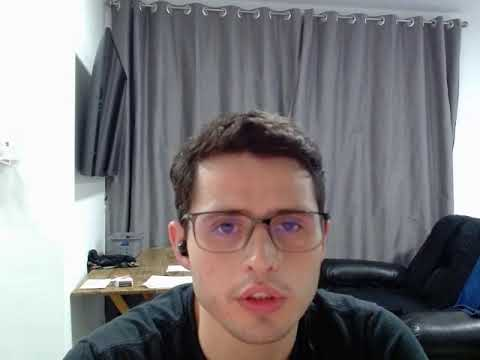

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('jVLb-jvQmWI')

# below is a really short video introduction on this project (under 2 minutes)

# **Analyzing Youtube channels that I am subscribed to using its API.**

I love watching Youtube. It's a very diverse streaming service (even before this word was cool), with videos ranging from comedy to science and curiosity, short or long, from channels with millions of subscribers to small comunnities with just a few hundred. 

But content creators suffer from "punitive algorithms" (in their words) that increase or decrease their visibility based on a plethora of metrics, more often than ever unknown to them. From YT perspective it's actually understandable, since a lot of viewers are migrating to other platforms (Tiktok, Twitch and an ever growing streaming services options). They need to maximize the amount of viewers and time spent on each video to justify that Youtube is actually a good platform to place ads.

With this in mind I decided to use its API to collect some data and try to predict a video "view count" at the time it was published. Some models were built using video title features, thumbnail color, day and hour it was published, and so on. If successful, it could be used for example to fine tune ad placement in terms of expected return it will give. If unsuccessful it can at least be improved in future iterations.

![picture](https://drive.google.com/uc?export=view&id=1OAsDxFhsRTugNpJDoYhQ7dEIdLAg2fnX)


# **1) ETL**

*You'll need a Youtube API key and a Postgres DB on AWS RDS. The API key, db login and password needs to be inside a .env file in the first notebook.*

In this part I used Youtube's API to request and extract data from a list of 10 channels and videos that those channels published in a given period. Around 2.500 videos were extracted and store in a pandas dataframe.

Then I used regular expressions to extract the amount of words, "?", "!" and "..." symbols of each title. The next step was to transform video duration from ISO 8601 to seconds and then extracted the main color of each thumbnail. All of this was also store in the same df.

Finally, I used psycopg2 to connect to a Postgres DB on AWS RDS. Videos/channels are updated (if they already exist in the DB) or inserted (if they are new) in the DB. I simply divided the DB in two tables: "videos" and "channels".

# **2) Data analysis**

In this notebook I use a read-only user from the db to read data. Two transformations are needed: extract the name of the day from upload date, and the **local** upload hour (it should consider the timezone it was published on!!)

*  2857 videos are in the database (it's impressive, but some have the exact same title!).
*  View count, like count and comment count are all positively skewed.
*  Videos can be divided in two groups: one with many videos with a small amount of views, likes and comments; another one with less videos but with way more views, likes and comments. This can be more easily seen using the log distribution.
*  Videos are mostly published on Tuesday/Thursday, around lunch time and early evening.
*  Channel "UMotivo" has almost half of all videos in the database, and it could create biases. This reinforces the need to analyze each channel individually (it doesn't need to be in detail though).
  *  Video count (the amout of videos a channel has published) is positively correlated with the number of exclamation marks on titles. Since video count is a feature that is constant for each channel, this can be analyzed as -> channels that publishes more tend to use more exclamation marks on video titles. That's precisely the case for the channel "UMotivo" for example.
*  There's no clear pattern on day of the week or hour of the day a video was published and the amount of views it's going to have.
*  As expected, view count is positively correlated with like and comment count.
*  Subscriber count is positively correlated with like count; more subscribers equal more people who naturally like to watch a YT creator, so they naturally use the "like" button more.

When analyzing channels individually:
*  Some channels have a view count distribution curve that is a normal distribution, while others follow a power law.
*  Channels are really particular when choosing the day of the week they are going to publish, but all channels publishes around lunch time and early evening.

It was really hard to draw conclusions of which features the machine learning models would benefit more from. But all correlation plots indicates that the main color of a thumbnail has little importance. Nonetheless, models will be built using different features.

# **3) Prediction models**

Several prediction models were created, using different machine learning techniques:
*   A dummy model (simply the median of view count by channel)
*   Baseline model: Decision Tree Regressor
*   Challenger model: Histogram Gradient Boosting Regressor
*   Challenger model: Random Forest


When analyzing the data it helped a lot to use the log of view counts, so the model will be built exactly the same, that is, it will try to predict the amount of log views. The code is simply enough to use a function 'f' to transform the output and the corresponding 'f inverse' to transform it back to the original format.

I have created a prediciton pretty print method to convert back to the original format if it needs to.

The final result of each method is:

* Dummy model score:
    * 0.8986743311526758
* Baseline model 1 (decision tree, w/o channel_title feature) score:
    * 0.130234156464053
* Baseline model 2 (Decision tree, with channel_title feature) score:
    * 0.8767191632447643
*Challenger model 1 (HGBR, all features) score:
    * 0.9161204265820342
* Challenger model 2 (HGBR, all features but thumbnail color) score:
    * 0.9263967731200753
* Challenger model 3 (HGBR, only video duration and channel_title) score:
    * 0.9146466707112778
* Challenger model 4 (Random Forest, all features) score:
    * 0.9143962874084941
* Challenger model 5 (Random Forest, all features but thumbnail color) score:
    * 0.9267171187408957


Best models are HGBR using all feature but thumbnail color, and Random Forest using all features but thumbnail color. That's the expected result when we analyzed the correlation matrix of features. Thumbnail color wasn't correlated to view count.

Based on that, and the ease-of-use of implementation of this techniques, I would choose any of them over the Dummy model. But in an ideal scenario, more features would need to be extracted in order to increase prediction quality.

# **To-do**

I would like to work on other parts of this project:


1.   Get the number of words in the thumbnail (as well as features of these words)
2.   Use CV to count the number of human faces in the thumbnail (and possibly its emotion)
3.   Check if there are flashy elements in the thumbnail (red arrows for example)
4.   Redo models using new features
5.   Create individual models for **each** channel (this would be good to account for unbalanced dataset in terms of channels with a lot of videos published and channels with only a few). When trying to predict view count of a video from a channel not in the db, use the most similar channel model (or a combination of all models). Still need to think about this.

